In [125]:
from medmnist import PneumoniaMNIST
import numpy as np
from medmnist import INFO, Evaluator
import matplotlib.image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from skimage.io import imshow, imread,imsave
from skimage.util import random_noise
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
import dataset_without_pytorch

from dataset_without_pytorch import get_loader

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

PneumoniaMNIST(split='train',download=True, size=128)

Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz


Dataset PneumoniaMNIST of size 128 (pneumoniamnist_128)
    Number of datapoints: 4708
    Root location: /Users/christofferfuglkjaer/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [126]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [127]:
# load the data
train_dataset = DataClass(split='train', download=download,size = 128)
test_dataset = DataClass(split='test', download=download,size = 128)
val_dataset= DataClass(split='val', download=download,size = 128)


# encapsulate data into dataloader form
train_loader = get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = get_loader(dataset = test_dataset, batch_size=BATCH_SIZE)

Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz


In [128]:
train_file = np.load('/Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz')

x_train = train_file['train_images']
x_test = train_file['test_images']
x_val = train_file['val_images']
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_val=x_val.astype('float32') / 255.

print (x_val.shape)
print (x_test.shape)

(524, 128, 128)
(624, 128, 128)


In [129]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_val_noisy = x_val + noise_factor * tf.random.normal(shape=x_val.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
x_val_noisy = tf.clip_by_value(x_val_noisy, clip_value_min=0., clip_value_max=1.)


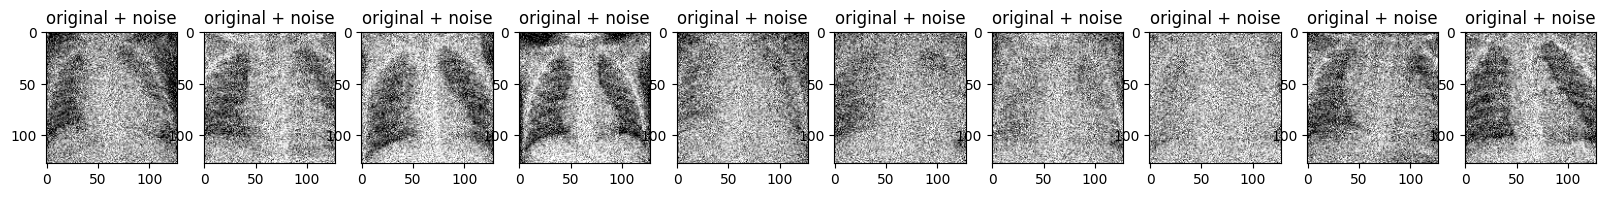

In [130]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [131]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Encoder

n = 128
chan = 1
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
#l3 = Dropout(0.3)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
#l3 = Dropout(0.5)(l3)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)
encoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 128, 128, 32)      160       
                                                                 
 conv2d_51 (Conv2D)          (None, 128, 128, 32)      4128      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 64, 64, 64)        8256      
                                                                 
 conv2d_53 (Conv2D)          (None, 64, 64, 64)        16448     
                                                          

In [132]:
# Decoder

l8 = UpSampling2D()(l6)

l9 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),)(l8)
l10 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
#l3 = Dropout(0.3)(l3)
l13 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is
autoencoder_hfenn = Model(input_img, decoded)
autoencoder.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 128, 128, 32)         160       ['input_6[0][0]']             
                                                                                                  
 conv2d_51 (Conv2D)          (None, 128, 128, 32)         4128      ['conv2d_50[0][0]']           
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)           0         ['conv2d_51[0][0]']           
 ng2D)                                                                                     

In [133]:
autoencoder.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 128, 128, 32)         160       ['input_6[0][0]']             
                                                                                                  
 conv2d_51 (Conv2D)          (None, 128, 128, 32)         4128      ['conv2d_50[0][0]']           
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)           0         ['conv2d_51[0][0]']           
 ng2D)                                                                                     

In [134]:
autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size = 16,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/25
295/295 [==============================] - 33s 107ms/step - loss: 0.0375 - val_loss: 0.0038
Epoch 2/25
295/295 [==============================] - 30s 101ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/25
295/295 [==============================] - 30s 101ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/25
295/295 [==============================] - 30s 101ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/25
295/295 [==============================] - 32s 107ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/25
295/295 [==============================] - 31s 106ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/25
295/295 [==============================] - 31s 104ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/25
295/295 [==============================] - 30s 101ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/25
295/295 [==============================] - 30s 102ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/25
295/295 [==============================] - 31s 105ms/step - l

/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_6469/3380963639.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(x_val[1])


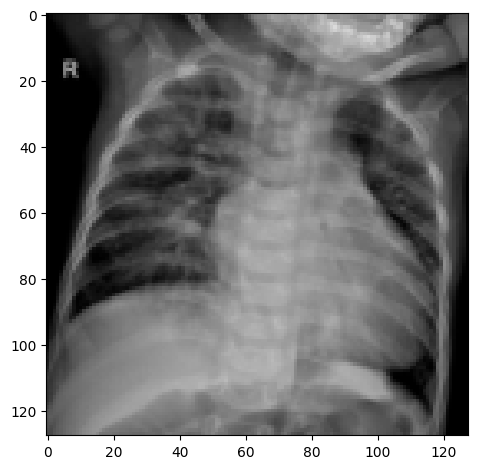

In [135]:
imshow(x_val[1])

In [136]:
decoded_imgs=autoencoder.predict(x_val_noisy)

17/17 [==============================] - 1s 45ms/step


/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_6469/79628611.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(decoded_imgs[1])


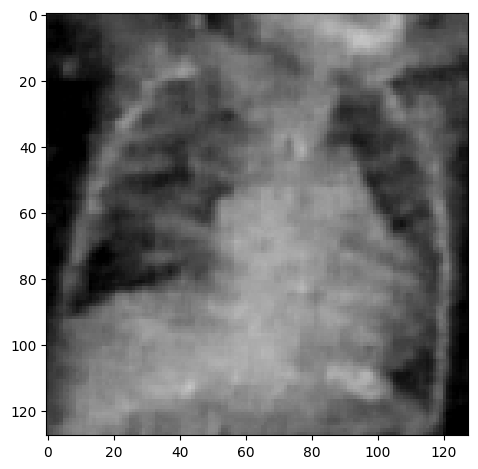

In [137]:
imshow(decoded_imgs[1])

In [138]:
# encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [139]:
def mse(orig, res):
    return ((orig - res) ** 2).mean()
     

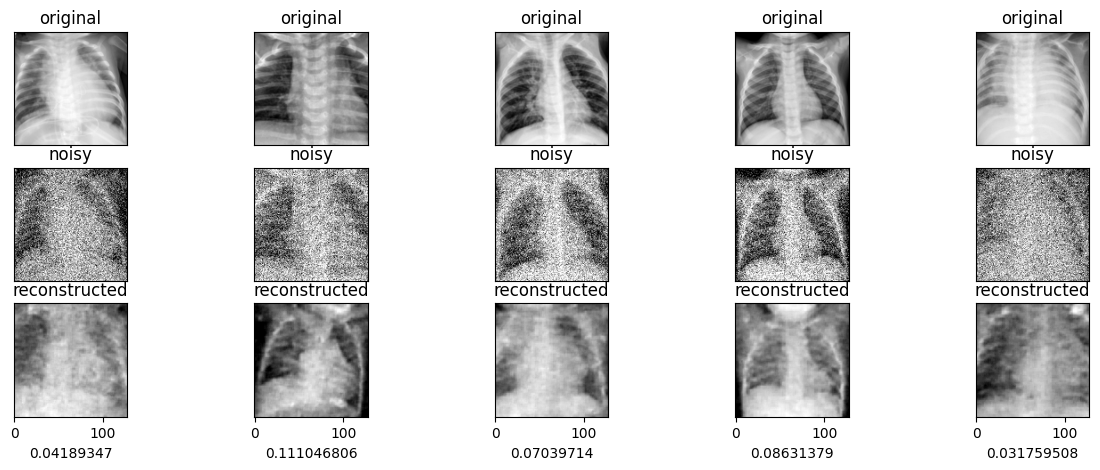

In [140]:
import matplotlib.pyplot as plt



n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(True)
    plt.xlabel(mse(x_test[i], decoded_imgs[i]))
    ax.get_yaxis().set_visible(False)

plt.show()

/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_6469/2126481622.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(decoded_imgs[2])


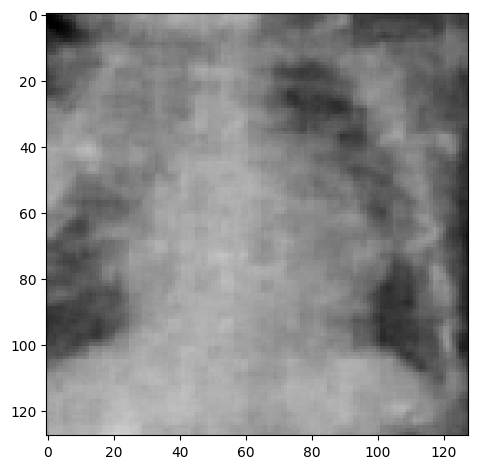

In [141]:
imshow(decoded_imgs[2])

/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_6469/3062952757.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(x_test[2])


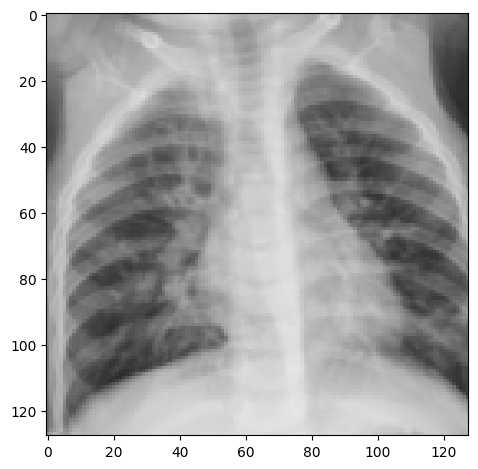

In [142]:
imshow(x_test[2])

In [143]:
image_noeffect = data[0]

def poiss_noise(image, var):
    col,row = image.shape
    sigma = var**0.5
    poiss = np.random.poisson(sigma,(row,col))
    poiss= poiss.reshape(row,col)
    noisy = image + poiss
    noisy = noisy.astype(np.uint8)

    return noisy

bil = poiss_noise(data[0])
print(bil.dtype)
imshow(bil,cmap = 'gray')

NameError: name 'data' is not defined

In [225]:
for i in range(1000):
    matplotlib.image.imsave('originale billeder/billede_udenstoej'+str(i)+".png", data[i],cmap='gray')

In [229]:
path = '/Users/christofferfuglkjaer/Library/CloudStorage/OneDrive-Aarhusuniversitet/studie/6.Semester/Bachelor/AUBachelor25/pneumoniamnist_224.npz'
def dataloader(Path, Noise_type):
    data = imread(Path)
    for i in range(1000):
        if Noise_type == 1:
            img = random_noise(poiss_noise(data[i]), mean =0, var = 0.001)
            #matplotlib.image.imsave('noised up/billede_medstoej'+str(i)+".png", random_noise(poiss_noise(data[i]), mean =0, var = 0.001),cmap='gray')
        if Noise_type == 2: # gaussian 
            img = random_noise(data[i], mean =0, var = 0.001)
            #matplotlib.image.imsave('test/billede'+str(i)+".png", random_noise(poiss_noise(data[i]), mean =0, var = 0.001),cmap='gray')
        if Noise_type == 3: # poiss
            img = poiss_noise(data[i], var = 100)
            #matplotlib.image.imsave('test/billede'+str(i)+".png", random_noise(poiss_noise(data[i]), mean =0, var = 0.001),cmap='gray')
            
dataloader(path,1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [62]:
noise_factor = 0.2
x_train_noisy = train + noise_factor * tf.random.normal(shape=train.shape)
x_test_noisy = test + noise_factor * tf.random.normal(shape=test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [63]:

test.shape

(256, 256, 1)

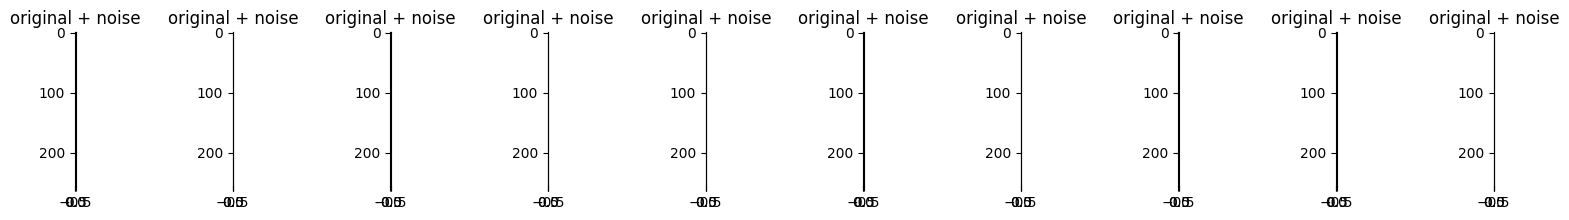

In [73]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i])
    plt.gray()
plt.show()

In [74]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 1)),
      layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2),
      
      layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
      
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
      
      
      
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()


shape = x_train.shape[1:]
latent_dim = 256
autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005), loss=losses.MeanSquaredError())

In [75]:


autoencoder.fit(x_train_noisy,train,
                epochs=5,
                shuffle=True,
                validation_data=(x_train_noisy,test))

Epoch 1/5
8/8 [==============================] - 4s 469ms/step - loss: 0.0421 - val_loss: 0.0226
Epoch 2/5
8/8 [==============================] - 3s 448ms/step - loss: 0.0353 - val_loss: 0.0258
Epoch 3/5
8/8 [==============================] - 3s 447ms/step - loss: 0.0342 - val_loss: 0.0222
Epoch 4/5
8/8 [==============================] - 3s 447ms/step - loss: 0.0340 - val_loss: 0.0228
Epoch 5/5
8/8 [==============================] - 3s 449ms/step - loss: 0.0339 - val_loss: 0.0234


In [79]:
encoded_imgs = autoencoder.encoder(test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs//255

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

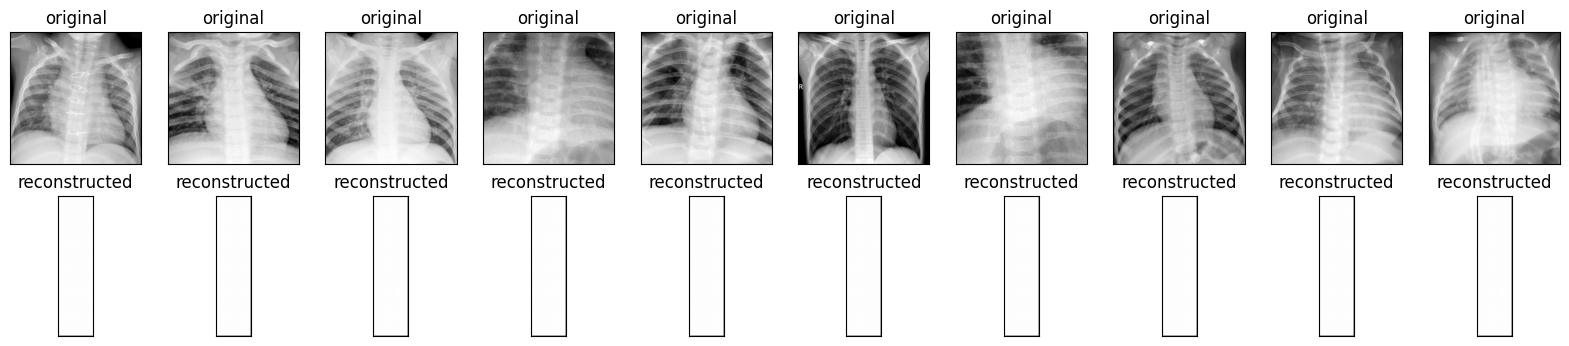

In [77]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(data[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()